# Create MURA training, validation, and test sets (NOISY VERSION)
The purpose of this notebook is to create an encoded MNIST dataset and split it in training, validation, and testing
Here, I will save the data for different Signal-to-Noise-Ratios

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme()

import torchvision.transforms as transforms
from torchvision import datasets
import torch

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [3]:
# Update plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,10],
})

In [4]:
%%time
# Compute MURA encoder and decoder
p = 23 # size of array (has to be prime)
A = mura.create_binary_aperture_arr(p)
G = mura.create_decoding_arr(A)

CPU times: user 1.78 ms, sys: 154 µs, total: 1.93 ms
Wall time: 2.13 ms


Text(0.5, 1.0, 'Decoder')

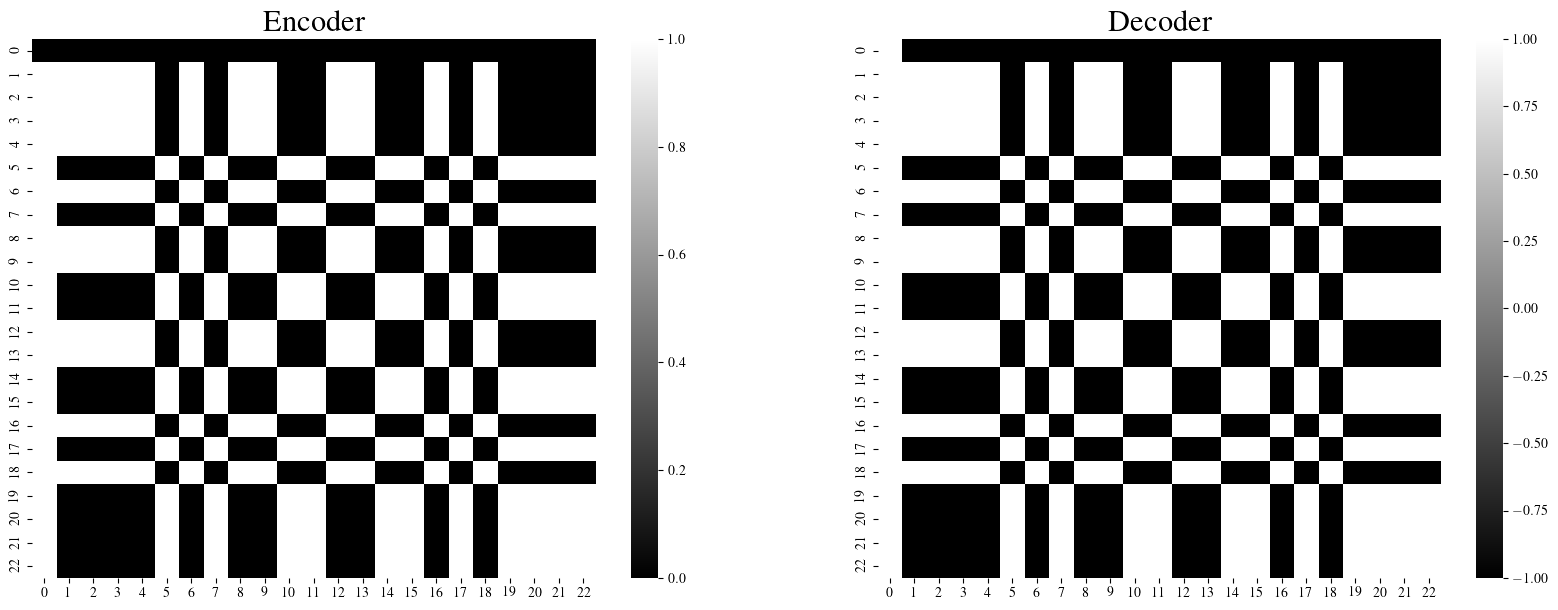

In [5]:
fig, axs = plt.subplots(1,2, figsize=(20,7))
axs = axs.ravel()

sns.heatmap(A, cmap='gray', ax=axs[0])
axs[0].set_title("Encoder", fontsize=22)

sns.heatmap(G, cmap='gray', ax=axs[1])
axs[1].set_title("Decoder", fontsize=22)

In [6]:
# Load MNIST data from PyTorch and
    # (1) Convert to tensor
    # (2) Resize from 28x28 to pxp 
    # (3) Normalize entries between [0,1]
train_data = datasets.MNIST(
    root = '../data/',
    train = True,                         
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(p),
                    transforms.Normalize(0, 1)
                ]), 
    download = False,            
)

test_data = datasets.MNIST(
    root = '../data/', 
    train = False, 
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(p),
                    transforms.Normalize(0, 1)
                ]) 
)

# Make original data noisy

In [7]:
def add_Gaussian_noise(og_image, desired_snr):
    '''
    Given an image and a desired Signal to Noise Ratio (in decibels, dB)
    returns a noisy image
    
    Inputs:
        og_image: Tensor. Original (noiseless) image normalized to pixel values [0,1]
        desired_snr: Integer. Signal to noise ration in decibels
        
    Outputs: 
        noisy_image: Tensor. Noisy version of original image. Values are between 0 and 1.  
    '''
    # Calculate the variance of the image pixels
    signal_power = torch.var(og_image)

    # # Set the desired SNR
    # desired_snr = 30

    # Calculate the noise power
    noise_power = signal_power / (10**(desired_snr/10))

    # Generate random noise matrix
    noise = torch.normal(0,torch.sqrt(noise_power), size=og_image.shape)

    # Add the noise to the image
    noisy_image = og_image + noise

    noisy_image = torch.clip(noisy_image, 0, 1)#.astype(torch.float32)
    
    return noisy_image

## Transform MNIST data
MNIST is only saved as training and testing datasets. We want to separate the data into training, validation, and testing.  
For this, I will do the following split: 80% training, 10% validation, and 10% testing. To get these quantities in code, I will have to hardcode some numbers. 

The result will be a noisy dataset given a SNR in decibels

In [8]:
%%time

# Transform the the whole dataset into a list by concatenating training and testing
all_data_list   = list(train_data) + list(test_data)
print(f'Length of whole dataset is {len(all_data_list)}.')


# ------------------ Create new set of training, validation, and testing 
# Define list to save encoded image and original image data
mura_all_data = []
desired_snr = 1
for idx in range(len(all_data_list)):
    # Get the whole dataset
    img_label_list = list(all_data_list[idx])
    
    # Get the noiseless image,  generate coded image, and add noise to coded image
    noiseless_image = all_data_list[idx][0]
    encoded_image = torch.unsqueeze(torch.tensor(mura.normalize(mura.FFT_convolve(np.squeeze(noiseless_image.numpy()), A,p)), dtype= torch.float), 0)
    noisy_encoded_image = mura.add_Gaussian_noise(encoded_image, desired_snr)
    
    # Data will be saved as a tuple of (noisy encoded image, noiseless image, number, noise level) 
    # For the encoded image, do FFT convolve and then normalize images
    img_label_list[0] = noisy_encoded_image
    img_label_list[1] = noiseless_image
    #img_label_list.append(noiseless_image)
    img_label_list.append(all_data_list[idx][1])
    img_label_list.append(f'{desired_snr}dB')
    mura_all_data.append(tuple(img_label_list))
    
print(f'Done! Length of encoded data list is : {len(mura_all_data)}')

Length of whole dataset is 70000.
Done! Length of encoded data list is : 70000
CPU times: user 28.6 s, sys: 452 ms, total: 29.1 s
Wall time: 29.2 s


In [8]:
%%time

# Transform the the whole dataset into a list by concatenating training and testing
all_data_list   = list(train_data) + list(test_data)
print(f'Length of whole dataset is {len(all_data_list)}.')


# ------------------ Create new set of training, validation, and testing 
# Define list to save encoded image and original image data
mura_all_data = []
desired_snr = 1
for idx in range(len(all_data_list)):
    # Get the whole dataset
    img_label_list = list(all_data_list[idx])
    
    # Get the noiseless image,  generate coded image, and add noise to coded image
    noiseless_image = all_data_list[idx][0]
    encoded_image = torch.unsqueeze(torch.tensor(mura.normalize(mura.FFT_convolve(np.squeeze(noiseless_image.numpy()), A,p)), dtype= torch.float), 0)
    noisy_encoded_image = mura.add_Gaussian_noise(encoded_image, desired_snr)
    reconstructed_noisy_encoded = torch.unsqueeze(torch.tensor(mura.normalize(mura.FFT_convolve(np.squeeze(noisy_encoded_image.numpy()), G, p)), dtype= torch.float),0)
    
    # Data will be saved as a tuple of (reconstructed noisy encoded image, noiseless image, number, noise level) 
    # For the encoded image, do FFT convolve and then normalize images
    img_label_list[0] = reconstructed_noisy_encoded
    img_label_list[1] = noiseless_image
    img_label_list.append(all_data_list[idx][1])
    img_label_list.append(f'{desired_snr}dB')
    mura_all_data.append(tuple(img_label_list))
    
print(f'Done! Length of encoded data list is : {len(mura_all_data)}')

Length of whole dataset is 70000.
Done! Length of encoded data list is : 70000
CPU times: user 38 s, sys: 846 ms, total: 38.9 s
Wall time: 39.2 s


In [9]:
# Separate into training, validation and testing
# Splits of 80, 10, and 10 percent of 70000
mura_train_data = mura_all_data[:int(len(mura_all_data)*0.8)]
mura_eval_data  = mura_all_data[int(len(mura_all_data)*0.8):int(len(mura_all_data)*0.9)]
mura_test_data  = mura_all_data[int(len(mura_all_data)*0.9):] 

print(f"Number of elements in each dataset \nTraining: {len(mura_train_data)} \nValidation: {len(mura_eval_data)} \nTesting: {len(mura_test_data)}")

Number of elements in each dataset 
Training: 56000 
Validation: 7000 
Testing: 7000


# Visualize data

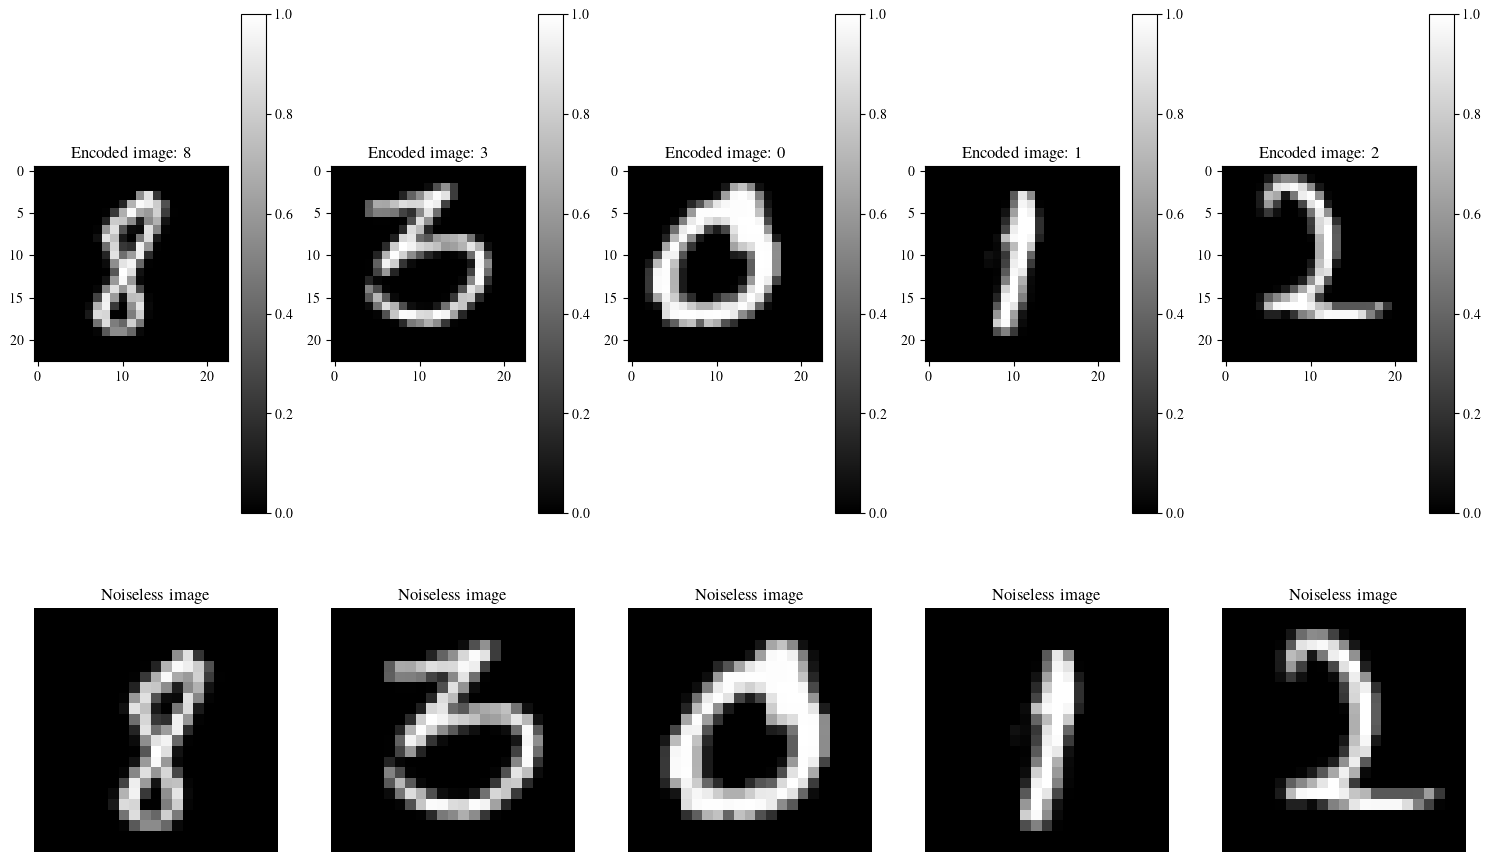

In [11]:
# Printing 25 random images from the training dataset
random_samples = np.random.randint(1, len(mura_train_data), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    encoded_image = mura_train_data[idx][0][0].numpy()
    noiseless_image = mura_train_data[idx][1][0].numpy()
    digit = mura_train_data[idx][2]
    snr = mura_train_data[idx][3]
    plt.subplot(2, 5, count + 1)
    plt.imshow(encoded_image, cmap='gray')
    plt.colorbar()
    plt.title(f'Encoded image: {digit} with SNR = {snr}')
    
    plt.subplot(2, 5, count + 6)
    plt.imshow(noiseless_image, cmap='gray')
    plt.title('Noiseless image')
    plt.axis('off')
    
    count += 1
plt.tight_layout()
#plt.savefig("../figs/encoded_original_examples.png")
plt.show()

## Make sure each set is well balanced

In [11]:
# Save lists of just the digits in each set
all_digits = [mura_all_data[i][2] for i in range(len(mura_all_data))]
train_digits = [mura_train_data[i][2] for i in range(len(mura_train_data))]
eval_digits  = [mura_eval_data[i][2] for i in range(len(mura_eval_data))]
test_digits  = [mura_test_data[i][2] for i in range(len(mura_test_data))]

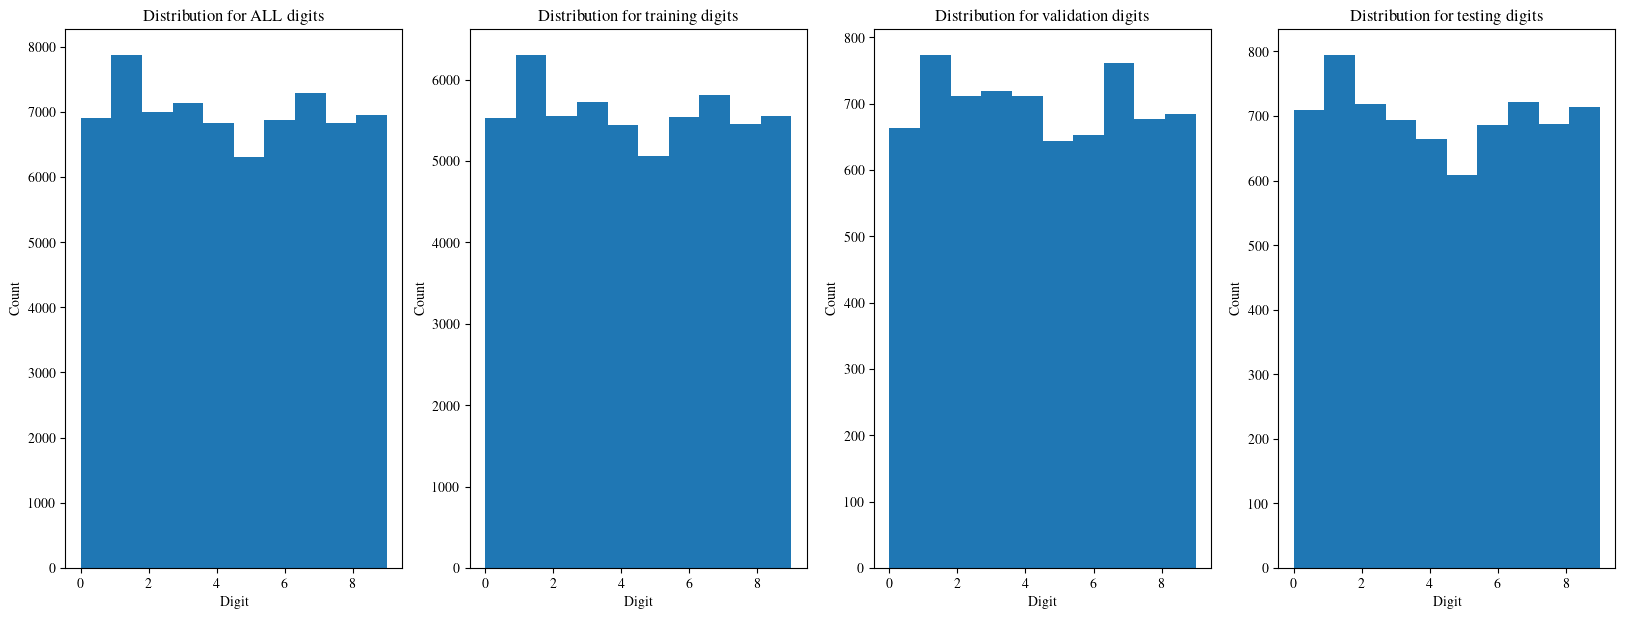

In [12]:
fig, axs = plt.subplots(1,4, figsize=(20,7))
axs = axs.ravel()
axs[0].hist(all_digits)
axs[0].set_title("Distribution for ALL digits")

axs[1].hist(train_digits)
axs[1].set_title("Distribution for training digits")

axs[2].hist(eval_digits)
axs[2].set_title("Distribution for validation digits")

axs[3].hist(test_digits)
axs[3].set_title("Distribution for testing digits")

for i in range(4):
    axs[i].set_xlabel("Digit")
    axs[i].set_ylabel("Count")
plt.show()

# Save Data

In [13]:
filename_train = f"../data/MNIST/training_MNIST_mura_{desired_snr}dB"
filename_eval = f"../data/MNIST/validation_MNIST_mura_{desired_snr}dB"
filename_test = f"../data/MNIST/testing_MNIST_mura_{desired_snr}dB"

In [12]:
%%time

# Save encoded data 
torch.save(mura_train_data, filename_train)
torch.save(mura_eval_data, filename_eval)
torch.save(mura_test_data, filename_test)

CPU times: user 4.38 s, sys: 1.98 s, total: 6.37 s
Wall time: 7.09 s
